### Import libraries, define directiories

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

2024-07-19 13:02:45.520410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 13:02:45.540916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 13:02:45.540949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 13:02:45.552598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 13:02:46.484503: W tensorflow/compiler/tf

Directories

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


## MoveNet, keypoints recognition

Helper functions for visualization

In [3]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'fuchsia',
    (7, 9): 'fuchsia',
    (6, 8): 'darkcyan',
    (8, 10): 'darkcyan',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

Choose Movenet model between
- lightning
- thunder

Args:
input_image: A [1, height, width, 3] tensor represents the input image
pixels. Note that the height/width should already be resized and match the
expected input resolution of the model before passing into this function.

Returns:
A [1, 1, 17, 3] float numpy array representing the predicted keypoint
coordinates and scores.

In [4]:
model_name = "movenet_lightning" 
#@param ["movenet_lightning", "movenet_thunder"]

In [5]:
if "movenet_lightning" in model_name:
    module = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-lightning/4")
    input_size = 192
    print('Loading MoveNet lightning, expected input size for the image: ', input_size)
elif "movenet_thunder" in model_name:
    module = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-thunder/4")
    input_size = 256
    print('Loading MoveNet thunder, expected input size for the image: ', input_size)
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image):
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

Loading MoveNet lightning, expected input size for the image:  192


#### Single image example

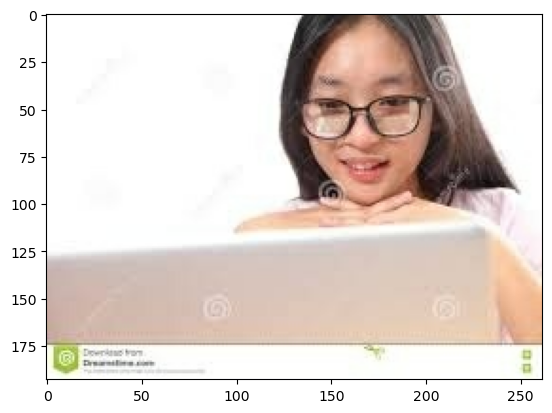

In [6]:
image_path = data_directory + '/train/Image_87.jpg'

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [7]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

keypoints_with_scores

array([[[[0.3925037 , 0.63268316, 0.58771706],
         [0.3115843 , 0.6959971 , 0.7006754 ],
         [0.3167591 , 0.5705619 , 0.72602856],
         [0.32398686, 0.77779853, 0.5682323 ],
         [0.3251304 , 0.5180346 , 0.630519  ],
         [0.5201583 , 0.91241425, 0.55532134],
         [0.5586628 , 0.42983696, 0.44049466],
         [0.7819881 , 0.9747467 , 0.42526802],
         [0.84823954, 0.42761987, 0.11238839],
         [0.74284005, 0.8161833 , 0.07040728],
         [0.7663183 , 0.60522866, 0.15183659],
         [0.84509915, 0.82199466, 0.12813504],
         [0.83956283, 0.5379875 , 0.16537735],
         [0.77466434, 0.91691536, 0.07555524],
         [0.73181355, 0.3473845 , 0.04898784],
         [0.77998364, 0.6696002 , 0.11260158],
         [0.8106183 , 0.59120154, 0.17633036]]]], dtype=float32)

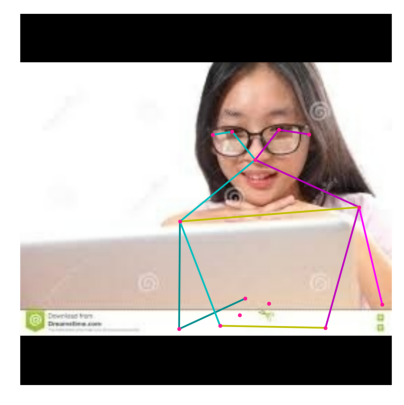

In [8]:
# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

### Batch Process
Load dataframe with training images

In [9]:
df = pd.read_csv(data_directory+'/Training_set.csv')
df.head(10)

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
5,Image_6.jpg,sleeping
6,Image_7.jpg,drinking
7,Image_8.jpg,hugging
8,Image_9.jpg,clapping
9,Image_10.jpg,dancing


convert labels from text to numerical

In [10]:
df['label'] = df['label'].astype('category')
df['category'] = df['label'].cat.codes
df.head(10)

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
5,Image_6.jpg,sleeping,12
6,Image_7.jpg,drinking,4
7,Image_8.jpg,hugging,7
8,Image_9.jpg,clapping,1
9,Image_10.jpg,dancing,3


define a function that takes as input the image path and returns the image with the keypoints and the category

In [11]:
def image_keypoints(image_path, norm = True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image).reshape(17,3)
    
    if norm:
        norm_factor_x = np.percentile(keypoints_with_scores[:, 0], 95) - np.percentile(keypoints_with_scores[:, 0], 5)
        norm_factor_y = np.percentile(keypoints_with_scores[:, 1], 95) - np.percentile(keypoints_with_scores[:, 1], 5)

        keypoints_with_scores[:, 0] = (keypoints_with_scores[:, 0] - np.percentile(keypoints_with_scores[:, 0], 5)) / norm_factor_x
        keypoints_with_scores[:, 1] = (keypoints_with_scores[:, 1] - np.percentile(keypoints_with_scores[:, 1], 5)) / norm_factor_y

    return keypoints_with_scores

In [12]:
image_path = data_directory + '/train/Image_87.jpg'
data = image_keypoints(image_path)
data

array([[ 0.14486629,  0.42775503,  0.58771706],
       [-0.00781097,  0.55024076,  0.7006754 ],
       [ 0.00195277,  0.30757663,  0.72602856],
       [ 0.01558995,  0.7084919 ,  0.5682323 ],
       [ 0.01774757,  0.2059585 ,  0.630519  ],
       [ 0.38572258,  0.9689164 ,  0.55532134],
       [ 0.45837215,  0.0353334 ,  0.44049466],
       [ 0.8797382 ,  1.0895033 ,  0.42526802],
       [ 1.0047402 ,  0.03104428,  0.11238839],
       [ 0.8058744 ,  0.78275025,  0.07040728],
       [ 0.85017276,  0.3746422 ,  0.15183659],
       [ 0.998815  ,  0.79399276,  0.12813504],
       [ 0.98836917,  0.2445589 ,  0.16537735],
       [ 0.8659199 ,  0.9776241 ,  0.07555524],
       [ 0.7850698 , -0.12417722,  0.04898784],
       [ 0.87595624,  0.49917385,  0.11260158],
       [ 0.9337571 ,  0.34750563,  0.17633036]], dtype=float32)

Process the whole dataframe at once

In [64]:
def keypoints_from_df(df, data_directory, train=True):
    
    keypoints = np.zeros((len(df),17,3))
    
    for i, file in enumerate(df['filename']):
        if train:
            keypoints[i,:,:] = image_keypoints(data_directory + '/train/' + file)
        else:
            keypoints[i,:,:] = image_keypoints(data_directory + '/test/' + file)
        
    return keypoints

In [68]:
def add_kpoints_dataframe(df, data_directory, train=True):
    
    df = df.astype('object')
    df['keypoints'] = np.zeros((len(df),51)).tolist()

    kds = keypoints_from_df(df, data_directory, train=train).reshape(-1, 51).tolist()
    df['keypoints'] = kds

    return df

Compute keypoints for the whole dataframe

In [15]:
# add_points_dataframe(df, data_directory)

In [16]:
testdf = df
testdf

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
...,...,...,...
12595,Image_12596.jpg,sitting,11
12596,Image_12597.jpg,clapping,1
12597,Image_12598.jpg,sitting,11
12598,Image_12599.jpg,dancing,3


In [17]:
testdf = add_kpoints_dataframe(testdf, data_directory)
testdf

,filename,label,category,keypoints
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5..."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7..."
...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0...."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0...."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596..."


## MobileNet, object recognition

In [18]:
from keras.applications.mobilenet_v3 import decode_predictions

In [19]:
mobile_net = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_preprocessing=True)

/home/alessio/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


#### Single image example

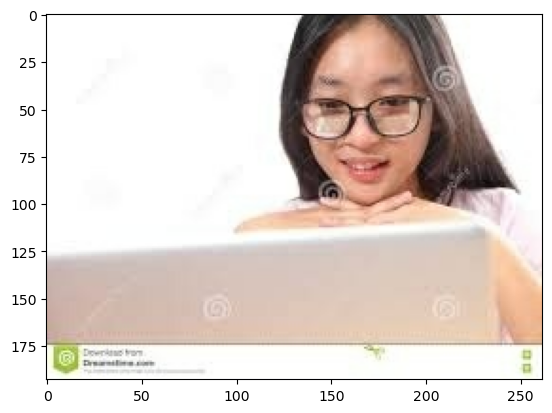

In [20]:
image_path = data_directory + '/train/Image_87.jpg'

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [21]:
def load_prepare_image(image_path, expand_dims=True):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    if expand_dims:
        img = np.expand_dims(img, axis=0)  
    
    return img

Use MoveNet to predict the objects in the image

In [22]:
obj_pred = mobile_net.predict(load_prepare_image(image_path))
obj_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 1000)

Print top predictions along with scores

In [23]:
for desc in decode_predictions(obj_pred)[0]:
    print(desc)

('n03832673', 'notebook', 0.32086468)
('n03642806', 'laptop', 0.20639703)
('n06359193', 'web_site', 0.071982495)
('n03485407', 'hand-held_computer', 0.060847186)
('n04009552', 'projector', 0.025987238)


### Batch Process

In [24]:
df.head(10)

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
5,Image_6.jpg,sleeping,12
6,Image_7.jpg,drinking,4
7,Image_8.jpg,hugging,7
8,Image_9.jpg,clapping,1
9,Image_10.jpg,dancing,3


In [65]:
def object_rec(df, data_directory, train=True):
    images = df['filename']
    obj_list = []
    
    for i, image in enumerate(images):
        if train:
            image_path = data_directory + '/train/' + image
        else:
            image_path = data_directory + '/test/' + image
            
        obj_pred = mobile_net.predict(load_prepare_image(image_path), verbose=0)
        obj_list.append(obj_pred)

    df['object'] = np.zeros((len(df), 1000)).tolist()    
    df['object'] = obj_list
    
    df['obj_label'] = df['object'].apply(lambda x: np.argsort(x[0])[::-1][:5])
    df['object'] = df['object'].apply(lambda x: np.sort(x[0])[::-1][:5])
    
    return df

In [26]:
testdf = object_rec(testdf, data_directory)

In [27]:
testdf

,filename,label,category,keypoints,object,obj_label
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[0.60480165, 0.04718776, 0.032203343, 0.022124...","[697, 789, 822, 514, 614]"
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[0.7418762, 0.040941585, 0.012892539, 0.008574...","[831, 416, 669, 697, 681]"
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[0.1416007, 0.13604547, 0.05453948, 0.04444576...","[697, 522, 984, 529, 416]"
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[0.6505104, 0.06191667, 0.027490702, 0.0246344...","[678, 691, 680, 529, 823]"
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[0.71057284, 0.10088889, 0.035408325, 0.016313...","[490, 655, 689, 824, 601]"
...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[0.23895389, 0.14317973, 0.076097175, 0.056834...","[706, 905, 624, 559, 831]"
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[0.8603377, 0.021510318, 0.016789775, 0.009536...","[617, 823, 678, 904, 905]"
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[0.48068434, 0.07919033, 0.043129846, 0.026711...","[608, 743, 843, 487, 543]"
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[0.15199172, 0.068358354, 0.059058633, 0.04262...","[416, 615, 747, 617, 587]"


## Word Vectorization

In [28]:
import gensim.downloader
import wordninja

In [29]:
#available("glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200")
word_vec_model = "glove-wiki-gigaword-100"

In [30]:
vectorize_label = gensim.downloader.load(word_vec_model) 

In [31]:
objects_vocabulary = []
with open(root_directory + 'mobilenet_dic.txt', 'r') as f:
    for line in f:
        objects_vocabulary.append(line.replace('-', ' ').replace("'s","").strip().split(','))

In [32]:
objects_vocabulary

[['background'],
 ['tench', ' Tinca tinca'],
 ['goldfish', ' Carassius auratus'],
 ['great white shark',
  ' white shark',
  ' man eater',
  ' man eating shark',
  ' Carcharodon carcharias'],
 ['tiger shark', ' Galeocerdo cuvieri'],
 ['hammerhead', ' hammerhead shark'],
 ['electric ray', ' crampfish', ' numbfish', ' torpedo'],
 ['stingray'],
 ['cock'],
 ['hen'],
 ['ostrich', ' Struthio camelus'],
 ['brambling', ' Fringilla montifringilla'],
 ['goldfinch', ' Carduelis carduelis'],
 ['house finch', ' linnet', ' Carpodacus mexicanus'],
 ['junco', ' snowbird'],
 ['indigo bunting', ' indigo finch', ' indigo bird', ' Passerina cyanea'],
 ['robin', ' American robin', ' Turdus migratorius'],
 ['bulbul'],
 ['jay'],
 ['magpie'],
 ['chickadee'],
 ['water ouzel', ' dipper'],
 ['kite'],
 ['bald eagle', ' American eagle', ' Haliaeetus leucocephalus'],
 ['vulture'],
 ['great grey owl', ' great gray owl', ' Strix nebulosa'],
 ['European fire salamander', ' Salamandra salamandra'],
 ['common newt', ' T

In [33]:
cleaned_vocabulary = []

for alias in objects_vocabulary:
    
    # Step 1 - Keep only the first alias
    alias = alias[0]
    
    # Step 2 - Basic preprocessing (lowercase, remove whitespaces, )
    alias = alias.lower().strip().split()
    
    cleaned_vocabulary.append(alias)
    
    
cleaned_vocabulary

[['background'],
 ['tench'],
 ['goldfish'],
 ['great', 'white', 'shark'],
 ['tiger', 'shark'],
 ['hammerhead'],
 ['electric', 'ray'],
 ['stingray'],
 ['cock'],
 ['hen'],
 ['ostrich'],
 ['brambling'],
 ['goldfinch'],
 ['house', 'finch'],
 ['junco'],
 ['indigo', 'bunting'],
 ['robin'],
 ['bulbul'],
 ['jay'],
 ['magpie'],
 ['chickadee'],
 ['water', 'ouzel'],
 ['kite'],
 ['bald', 'eagle'],
 ['vulture'],
 ['great', 'grey', 'owl'],
 ['european', 'fire', 'salamander'],
 ['common', 'newt'],
 ['eft'],
 ['spotted', 'salamander'],
 ['axolotl'],
 ['bullfrog'],
 ['tree', 'frog'],
 ['tailed', 'frog'],
 ['loggerhead'],
 ['leatherback', 'turtle'],
 ['mud', 'turtle'],
 ['terrapin'],
 ['box', 'turtle'],
 ['banded', 'gecko'],
 ['common', 'iguana'],
 ['american', 'chameleon'],
 ['whiptail'],
 ['agama'],
 ['frilled', 'lizard'],
 ['alligator', 'lizard'],
 ['gila', 'monster'],
 ['green', 'lizard'],
 ['african', 'chameleon'],
 ['komodo', 'dragon'],
 ['african', 'crocodile'],
 ['american', 'alligator'],
 ['tri

Introducing Word Ninja
It splits composite words into basic words -> ex. "ashtray" -> "ash" + "tray"

In [34]:
def label_to_vector(vocabulary):
    
    word_vectors = []
    
    standard = 0
    wninja = 0
    
    for word in vocabulary:
        #rint(word)
        try:
            word_vectors.append(np.sum([vectorize_label[wi]for wi in word], axis=0))
            standard += 1
        except:
            word = ([wordninja.split(w) for w in word])[0]
            word = [w for w in word if len(w)>2]
            try:
                word_vectors.append(np.sum([vectorize_label[wi]for wi in word], axis=0))
                wninja += 1
            except:
                print(word)
                word_vectors.append(np.zeros(100))
    
    print("Vectorized normally: " , standard , '\n', 'Vectorized with wordninja: ', wninja, '\n', "Not vectorized: ", len(vocabulary)-standard-wninja)
    
    return word_vectors

In [35]:
vector_words_list = label_to_vector(cleaned_vocabulary)

['keeshond']
['jinrikisha']
['saltshaker']
Vectorized normally:  975 
 Vectorized with wordninja:  23 
 Not vectorized:  3


In [36]:
def add_vectors_dataframe(df):
    df['obj_vector'] = df['obj_label'].apply(lambda x: [vector_words_list[i+1].tolist() for i in x])
    df['obj_words'] = df['obj_label'].apply(lambda x: [cleaned_vocabulary[i+1] for i in x])

In [37]:
add_vectors_dataframe(testdf)

In [38]:
testdf

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[0.60480165, 0.04718776, 0.032203343, 0.022124...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[0.7418762, 0.040941585, 0.012892539, 0.008574...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[0.1416007, 0.13604547, 0.05453948, 0.04444576...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[0.6505104, 0.06191667, 0.027490702, 0.0246344...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[0.71057284, 0.10088889, 0.035408325, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[0.23895389, 0.14317973, 0.076097175, 0.056834...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding..."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[0.8603377, 0.021510318, 0.016789775, 0.009536...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w..."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[0.48068434, 0.07919033, 0.043129846, 0.026711...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[0.15199172, 0.068358354, 0.059058633, 0.04262...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]..."


## Final Preprocessing and write dataframe

In [39]:
def complete_preprocessing(df, data_directory, file_name = None, write=True):
    
    df = add_kpoints_dataframe(df, data_directory)
    df = object_rec(df, data_directory)
    add_vectors_dataframe(df)
    
    if write:
        print("Saving as: ", str(data_directory + '/' + file_name + '.csv'))
        df.to_csv(data_directory + '/' + file_name + '.csv', index=False)
    
    return df
    

In [48]:
# save a dataframe as a pickle file
def save_as_pickle(df, file_name):
    df.to_pickle(file_name + '.pkl')
    print("Saved as: ", file_name + '.pkl')

In [44]:
file_name = 'test_head_df'

finaltest = complete_preprocessing(df, data_directory, file_name)
finaltest

Saving as:  ../human_pose_local/archive/Human Action Recognition/test_head_df.csv


,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[0.60480165, 0.04718776, 0.032203343, 0.022124...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[0.7418762, 0.040941585, 0.012892539, 0.008574...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[0.1416007, 0.13604547, 0.05453948, 0.04444576...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[0.6505104, 0.06191667, 0.027490702, 0.0246344...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[0.71057284, 0.10088889, 0.035408325, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[0.23895389, 0.14317973, 0.076097175, 0.056834...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding..."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[0.8603377, 0.021510318, 0.016789775, 0.009536...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w..."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[0.48068434, 0.07919033, 0.043129846, 0.026711...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[0.15199172, 0.068358354, 0.059058633, 0.04262...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]..."


In [59]:
finaltest.to_pickle(data_directory + '/' + file_name + '.pkl')

In [60]:
# load the data
def load_pickle(file_name):
    return pd.read_pickle(file_name + '.pkl')

In [61]:
loaded_df = load_pickle(data_directory + '/' + file_name)
loaded_df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[0.60480165, 0.04718776, 0.032203343, 0.022124...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[0.7418762, 0.040941585, 0.012892539, 0.008574...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[0.1416007, 0.13604547, 0.05453948, 0.04444576...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[0.6505104, 0.06191667, 0.027490702, 0.0246344...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[0.71057284, 0.10088889, 0.035408325, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[0.23895389, 0.14317973, 0.076097175, 0.056834...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding..."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[0.8603377, 0.021510318, 0.016789775, 0.009536...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w..."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[0.48068434, 0.07919033, 0.043129846, 0.026711...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[0.15199172, 0.068358354, 0.059058633, 0.04262...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]..."


### Transform the test dataset

In [62]:
test_df = pd.read_csv(data_directory+'/Testing_set.csv')
test_df.head(10)

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
5,Image_6.jpg
6,Image_7.jpg
7,Image_8.jpg
8,Image_9.jpg
9,Image_10.jpg


In [69]:
def complete_preprocessing_test(df, data_directory, file_name = None, write=True):
    
    df = add_kpoints_dataframe(df, data_directory, train=False)
    df = object_rec(df, data_directory, train=False)
    add_vectors_dataframe(df)
        
    return df

In [70]:
test_data = complete_preprocessing_test(test_df, data_directory, 'test_head_df')

In [71]:
file_name = 'test_df'
test_data.to_pickle(data_directory + '/' + file_name + '.pkl')